<a href="https://colab.research.google.com/github/vitoriaferreirap/DeepLearning/blob/main/linear_regr_gd2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Regressão Linear

Esta primeira parte cobrirá:
* Uma simples implementação de uma rede neural
* Conceitos como função objetivo (target function) e função de custo (cost function)
* Otimização pelo gradiente descendente (gradient descent)

Tudo isso será ilustrado com a ajuda da rede neural mais simples possível: um modelo de regressão linear de 1 entrada e de 1 saída que tem como objetivo prever o valor-alvo $t$ a partir do valor de entrada $x$. A rede é definida como tendo uma entrada $ \mathbf{x}$ que é transformada pelo peso $w$ para gerar a saída $\mathbf{y}$ pela equação $\mathbf{y}=\mathbf{x}*w$, sendo que $\mathbf{y}$ precisa aproximar os targets $\mathbf{t}$ da melhor forma possível, conforme definido por uma função de custo. Esta rede pode ser representada graficamente como:

![Image of the simple neural network](https://peterroelants.github.io/images/neural_net_implementation/SimpleANN01.png)


Em redes neurais regulares, normalmente temos várias camadas, funções de ativação não lineares e um bieas para cada nó. Neste primeiro exemplo, temos apenas uma camada com um parâmetro de peso $w$, uma função de ativação $z=\phi(y)$ do tipo linear (i.e. $z=y$) na saída e nenhum bias.

## RESUMO:
- Modelo → nn(x, w) (regressão linear)
- Loss → cost(y, t)
- Gradiente → gradient(w, x, t)
- Regra de aprendizado → delta_w(...)
- Gradiente descendente iterativo → loop for

In [2]:
# Biblioteca para cálculo numérico (vetores, matrizes, derivadas discretas)
import numpy as np

# Biblioteca para visualização gráfica
import matplotlib.pyplot as plt

# Permite que os gráficos apareçam dentro do notebook
%matplotlib inline

# Fixa a valor aleatória para garantir reprodutibilidade
# (sempre gerar os mesmos dados ao rodar o código)
np.random.seed(seed=1)


## Definindo a função objetivo

Vamos amostrar 20 entradas $\mathbf{x}$ com distribuição uniforme entre 0 e 1, e então gerar os valores de saída de destino $\mathbf{t}$ pelo processo descrito acima. Estas entradas resultantes $\mathbf{x}$ e alvos $\mathbf{t}$ são representados um contra o outro na figura abaixo junto com a linha original $f(x)$ sem o ruído gaussiano. Note que $\mathbf{x}$ é um vetor de amostras de entrada individuais $x_i$, e que $\mathbf{t}$ é um vetor correspondente de valores alvo $t_i$.

In [3]:
# Vetor de entradas x (dados de entrada do modelo)
# 20 valores contínuos entre 0 e 1
x = np.random.uniform(0, 1, 20)

# Função verdadeira que gera os dados (desconhecida pelo modelo)
def f(x):
    return x * 2

# Variância do ruído gaussiano
noise_variance = 0.2

# Ruído aleatório (simula imperfeições do mundo real)
noise = np.random.randn(x.shape[0]) * noise_variance

# Targets observados (função verdadeira + ruído)
# t=2x+ruido
t = f(x) + noise


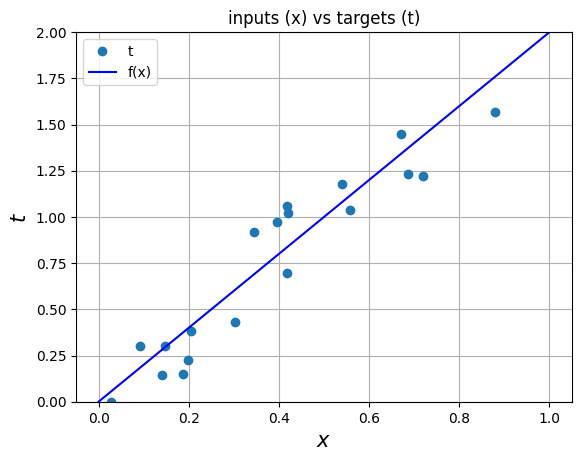

In [4]:
#Aqui vê o problema que a regressão linear precisa resolver

# Pontos observados (dados reais)
plt.plot(x, t, 'o', label='t')

# Linha da função verdadeira
plt.plot([0, 1], [f(0), f(1)], 'b-', label='f(x)')

plt.xlabel('$x$', fontsize=15)
plt.ylabel('$t$', fontsize=15)
plt.ylim([0,2])
plt.title('inputs (x) vs targets (t)')
plt.grid()
plt.legend(loc=2)
plt.show()


## Definindo a função de custo

Nós iremos otimizar o modelo $\mathbf{y} = \mathbf{x} * w$ ajustando o parâmetro $w$ de forma que a função de custo quadratica [squared error cost](http://en.wikipedia.org/wiki/Euclidean_distance#Squared_Euclidean_distance) ao longo de todas as amostras seja minimizado. O custo do erro quadrático é definido como:

$$\xi = \frac{1}{N}\sum_{i=1}^N \Vert y_i - t_i \Vert ^ 2$$

com $N$ o número de amostras no conjunto de treinamento. A meta de otimização é: $\underset{w}{\text{argmin}} \frac{1}{N}\sum_{i = 1}^{N} \Vert y_i - t_i \Vert ^ 2$.



In [5]:
# Aqui está o loss.

# MODELO
# Regressão linear: y = w * x
def nn(x, w):
    y = x * w
    return y

# Função de ativação identidade (não altera a saída)
def activation(y):
    z = y
    return z

# Função de custo (erro quadrático)
def cost(y, t):
    # 0.5 * (erro^2) somado para todas as amostras
    xi = (0.5 * (y - t)**2).sum()
    return xi

<>:14: SyntaxWarning: invalid escape sequence '\m'
<>:14: SyntaxWarning: invalid escape sequence '\m'
/tmp/ipython-input-1073197045.py:14: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel('$J(\mathbf{w})$', fontsize=15)


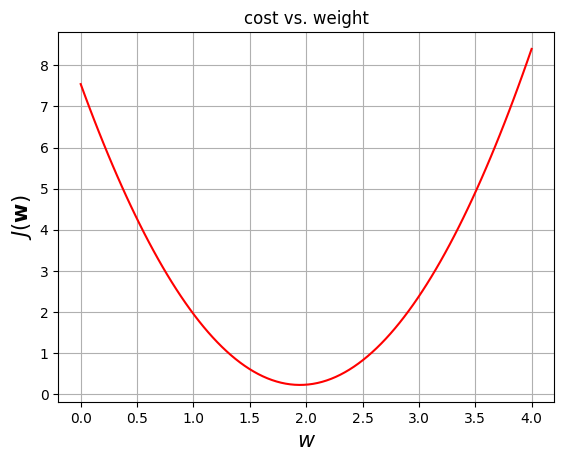

In [6]:
# Forma da função de erro (convexa)

# Conjunto de possíveis valores do peso w
ws = np.linspace(0, 4, num=100)

# Calcula o custo para cada valor de w
cost_ws = np.vectorize(
    lambda w: cost(activation(nn(x, w)), t)
)(ws)

# Gráfico da função de erro em relação ao peso
plt.plot(ws, cost_ws, 'r-')
plt.xlabel('$w$', fontsize=15)
plt.ylabel('$J(\mathbf{w})$', fontsize=15)
plt.title('cost vs. weight')
plt.grid()
plt.show()

## Otimizando a função de custo

Para uma função de custo simples, como neste exemplo, você pode ver facilmente qual deve ser o peso ideal. Mas a superfície de erro pode ser bastante [complexa](https://en.wikipedia.org/wiki/Rastrigin_function) ou ter uma alta dimensionalidade (cada parâmetro adicional $w_i$ adiciona uma nova dimensão). É por isso que usamos [técnicas de otimização](https://en.wikipedia.org/wiki/Mathematical_optimization) para encontrar o mínimo da função de erro.

### Gradiente descendente

Um algoritmo de otimização comumente usado para treinar redes neurais é o algoritmo do [gradient descent](http://en.wikipedia.org/wiki/Gradient_descent). O gradiente descendente funciona tomando a [derivada](http://en.wikipedia.org/wiki/Derivative) da função de custo $J(x)$ em relação aos parâmetros em uma posição específica nessa função de custo e atualiza os parâmetros na direção do gradiente negativo. O parâmetro $w$ é iterativamente atualizado, tomando medidas proporcionais ao negativo do gradiente:

$$w^{k+1} = w^k + \Delta w^k$$

Com $w^k$ sendo o valor de $w$ na iteração $k$ durante a descida do gradiente. $\Delta w$ é definido como:

$$\Delta w = -\eta \frac{\partial \xi}{\partial w}$$

Com $\eta$ sendo a taxa de aprendizado, que é o tamanho do salto, e  $\partial \xi / \partial w$ o gradiente da função de custo $\xi$ em relação ao peso $w$. Para cada amostra $i$ este gradiente pode ser dividido de acordo com a [regra da cadeia](http://en.wikipedia.org/wiki/Chain_rule).

Para iniciar o algoritmo de gradiente descendente, normalmente se inicia escolhendo os parâmetros iniciais aleatoriamente e começa a atualizar esses parâmetros com $\Delta w$ até a convergência. A taxa de aprendizado precisa ser ajustada separadamente como um hiperparâmetro para cada rede neural.


In [7]:
# Aqui acontece o aprendizado
# GRADIENTE (derivada da função de erro)

# Gradiente da função de custo em relação ao peso w
def gradient(w, x, t):
    return x * (activation(nn(x, w)) - t) # Se eu mexer em w, o erro sobe ou desce?

# Regra de aprendizado (Batch Gradient Descent)
def delta_w(w_k, x, t, learning_rate):
    # learning_rate * soma dos gradientes
    return learning_rate * gradient(w_k, x, t).sum()

# Peso inicial
w = 0.1

# Taxa de aprendizado
learning_rate = 0.1

# Número de iterações
nb_of_iterations = 4

# Armazena histórico (peso, custo)
w_cost = [(w, cost(nn(x, w), t))]

# Loop de aprendizado (gradiente descendente)
for i in range(nb_of_iterations):
    dw = delta_w(w, x, t, learning_rate)  # calcula correção
    w = w - dw                            # atualiza peso
    w_cost.append((w, cost(activation(nn(x, w)), t)))

Observe no resultado anterior que o algoritmo de descida de gradiente converge rapidamente para o valor alvo em torno de 2.0. Vamos tentar plotar essas iterações do algoritmo de gradiente descendente para visualizá-lo mais.

w(0): 0.1000 	 cost: 6.8099
w(1): 0.8139 	 cost: 2.6999
w(2): 1.2515 	 cost: 1.1554
w(3): 1.5197 	 cost: 0.5749
w(4): 1.6842 	 cost: 0.3568


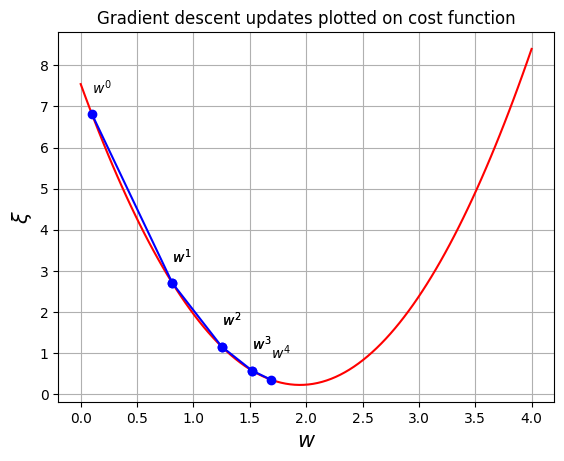

In [8]:

# Evolução do aprendizado
# Mostra como o peso e o erro evoluem
for i in range(len(w_cost)):
    print(f"w({i}): {w_cost[i][0]:.4f} \t cost: {w_cost[i][1]:.4f}")

plt.plot(ws, cost_ws, 'r-')

for i in range(0, len(w_cost)-1):
    w1, c1 = w_cost[i]
    w2, c2 = w_cost[i+1]
    plt.plot(w1, c1, 'bo')
    plt.plot([w1, w2],[c1, c2], 'b-')
    plt.text(w1, c1+0.5, '$w^{}$'.format(i))
    plt.plot(w2, c2, 'bo')
    plt.text(w2, c2+0.5, '$w^{}$'.format(i+1))

plt.xlabel('$w$', fontsize=15)
plt.ylabel('$\\xi$', fontsize=15)
plt.title('Gradient descent updates plotted on cost function')
plt.grid()
plt.show()

## Gradiente descendente iterativo

A última figura mostra as atualizações de gradiente descendente dos parâmetros de peso para 2 iterações. Os pontos azuis representam os valores dos parâmetros de peso $w^k$ na iteração $k$. Observe como a atualização difere da posição do peso e do gradiente naquele ponto. A primeira atualização leva um passo muito maior do que a segunda atualização porque o gradiente em $w^0$ é muito maior que o gradiente em $w^1$.

A linha de regressão ajustada por gradiente descendente com 10 iterações é mostrada na figura abaixo. A linha ajustada (vermelha) fica perto da linha original (azul), que é o que tentamos aproximar através das amostras com ruído. Note que ambas as linhas passam pelo ponto $(0,0)$, isto é porque nós não temos um termo de bias, que representa o intercept, o intercept em $x = 0$ é, portanto, $t = 0$.

In [9]:
# Treinamento final e reta aprendida
# Reinicia o peso
w = 0

# Mais iterações
nb_of_iterations = 10

for i in range(nb_of_iterations):
    dw = delta_w(w, x, t, learning_rate)
    w = w - dw


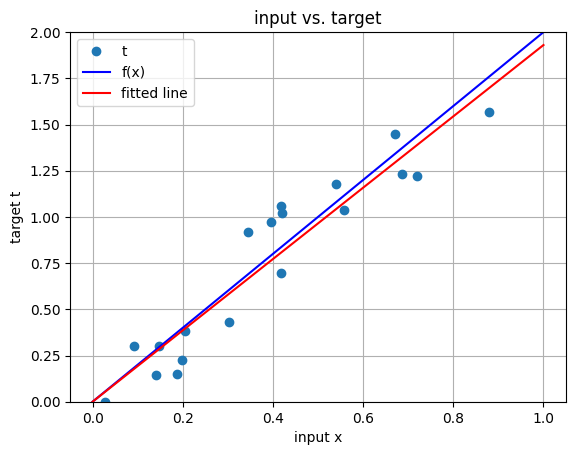

In [10]:
# Dados reais
plt.plot(x, t, 'o', label='t')

# Função verdadeira
plt.plot([0, 1], [f(0), f(1)], 'b-', label='f(x)')

# Reta aprendida pelo modelo
plt.plot([0, 1], [0*w, 1*w], 'r-', label='fitted line')

plt.xlabel('input x')
plt.ylabel('target t')
plt.ylim([0,2])
plt.title('input vs. target')
plt.grid()
plt.legend(loc=2)
plt.show()


# Análise

Sabemos que o GD convergirá se estabelermos uma taxa de aprendizado adequada. Então, a questão aqui é como a taxa de aprendizado afeta a convergência? Para esclarer, vamos mostrar algumas animações de GD aplicadas para encontrar o mínimo de $f(x) = x^2-4x + 2$.

![gradient3](https://miro.medium.com/max/600/1*Q-2Wh0Xcy6fsGkbPFJvMhQ.gif)

Pela figura acima vemos facilmente que, quanto mais você aumenta a taxa de aprendizado, mais rápido o seu GD converge. No entanto, se a taxa de aprendizado for muito grande ($\eta = 1.02$, por exemplo), o algoritmo irá divergir. Às vezes, seu algoritmo também pode convergir lentamente, embora você tenha definido uma grande taxa de aprendizado. A razão é explicada claramente na abaixo.

![gradient4](https://github.com/dalcimar/neural_net_implementation/blob/master/gradient4.gif?raw=true)

Escolher uma taxa de aprendizado adequada é um pouco difícil em Machine Learning (ML), algumas técnicas como validação, ajuste de hiperparâmetros e aprendizado adaptativo são utilizadas para solução desse problema. Vermos tais técnicas mais a frente.

### GD para funções não convexas

![gradient5](https://github.com/dalcimar/neural_net_implementation/blob/master/gradient5.png?raw=true)

A foto acima é um meme engraçado sobre o GD. Existem várias razões que fazem com que o GD não consiga encontrar a solução ideal, como a complexidade da função se ser minimizadao. Aqui nos concentramos no ponto inicial e na taxa de aprendizado.

#### Ponto inicial

Como mencionado, a posição do ponto de partida não afeta a convergência do GD muito nas funções convexas. No entanto, para as funções não-convexas, o ponto inicial desempenha um papel decisivo. Vamos ilustrar com animações sob uma função definida como $f(x) = x^2 + 8cos (x) - 3x$.

![gradient6](https://github.com/dalcimar/neural_net_implementation/blob/master/gradient6.gif?raw=true)

Como podemos ver, o ponto inicializado à direita converge para o mínimo global, enquanto o ponto mais à esquerda fica preso no mínimo local.
Outro exemplos de como o ponto inicial afeta a convergência pode ser dado pela função $f (x, y) = (1-\frac{1}{2}x + x^5 + y^3)^{e(-x^2-y^2)}$.

![gradient7](https://github.com/dalcimar/neural_net_implementation/blob/master/gradient7.gif?raw=true)

![gradient8](https://github.com/dalcimar/neural_net_implementation/blob/master/gradient8.gif?raw=true)
![gradient9](https://nikcheerla.github.io/deeplearningschool//media/loss3d.gif)

#### Taxa de Aprendizagem
Para funções não convexas, a taxa de aprendizado não é usada apenas para acelerar a velocidade de convergência, mas também para fazer com que o algoritmo escape dos mínimos locais. Uma demonstração clara é mostrada na figura abaixo:

![gradient9](https://github.com/dalcimar/neural_net_implementation/blob/master/gradient9.gif?raw=true)

Podemos ver que ajustando a taxa de aprendizado em $0.0005$ (número muito pequeno) nosso algoritmo convergiu para o mínimo global. Às vezes, uma pequena mudança faz algo grande. E se o exército prussiano chegasse a Waterloo um pouco tarde? Bem, Napoleão poderia esmagar o exército de Wellington e governar a Europa novamente. Quem sabe?

No entanto, uma taxa de aprendizado grande o suficiente às vezes não é uma boa escolha e pode causar o fenômeno de que a DG converge primeiro e depois oscilará ao redor dos mínimos como mostrado abaixo.

![gradient10](https://github.com/dalcimar/neural_net_implementation/blob/master/gradient10.gif?raw=true)

Embora o GD seja muito fácil de ficar preso em mínimos locais, ele ainda é usado amplamente porque beneficia a computação e a memória em comparação com outros algoritmos, como o método de Newton. Por causa disso, o GD é freqüentemente usado no Deep Learning. Mais a frente veremos variações do GD que, na verdade, adaptações da taxa de aprendizado do GD para ajudar o GD a convergir para um mínimo local melhor ou mesmo para o global.

#### Alternativas ao GD

![gradientnomomentuim](http://www.eleven-lab.co.jp/blog/wp-content/uploads/2019/08/nomomentum1d.gif)

![gradientmomentuim](http://www.eleven-lab.co.jp/blog/wp-content/uploads/2019/08/momentum1d.gif)

![gradientall](https://miro.medium.com/max/620/0*wWp-AHgQr-agFkwX.gif)
